## About Dataset
### Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Content
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.


## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.



In [45]:
#!pip install -U pip
#!pip install -U setuptools wheel
#!pip install -U "mxnet<2.0.0" bokeh==2.0.1
#!pip install autogluon --no-cache-dir
#!pip install kaggle
#!pip install python-dotenv
#!pip install missingno

#!pip install smdebug

In [3]:
import subprocess
subprocess.run("./setup.sh", shell=True)

subprocess.run("apt-get update -y", shell=True)
subprocess.run("apt install unzip", shell=True)

CompletedProcess(args='apt install unzip', returncode=0)

In [4]:
import os
import sys
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
%matplotlib inline

##  Data Preparation

In [5]:
df = pd.read_csv('diabetes.csv')

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Get column names

In [7]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## EDA

In [8]:
df.shape

(768, 9)

In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### The results of this summary of describe function.
There are some value of below listed columns have zero minimum, the value of zero does indicates missing value.

Following columns or variables have an invalid zero value:

 - Glucose
 - BloodPressure
 - SkinThickness
 - Insulin
 - BMI

These missing values can be replaced by nan this will help in counting.

## Ploting Data Distribution

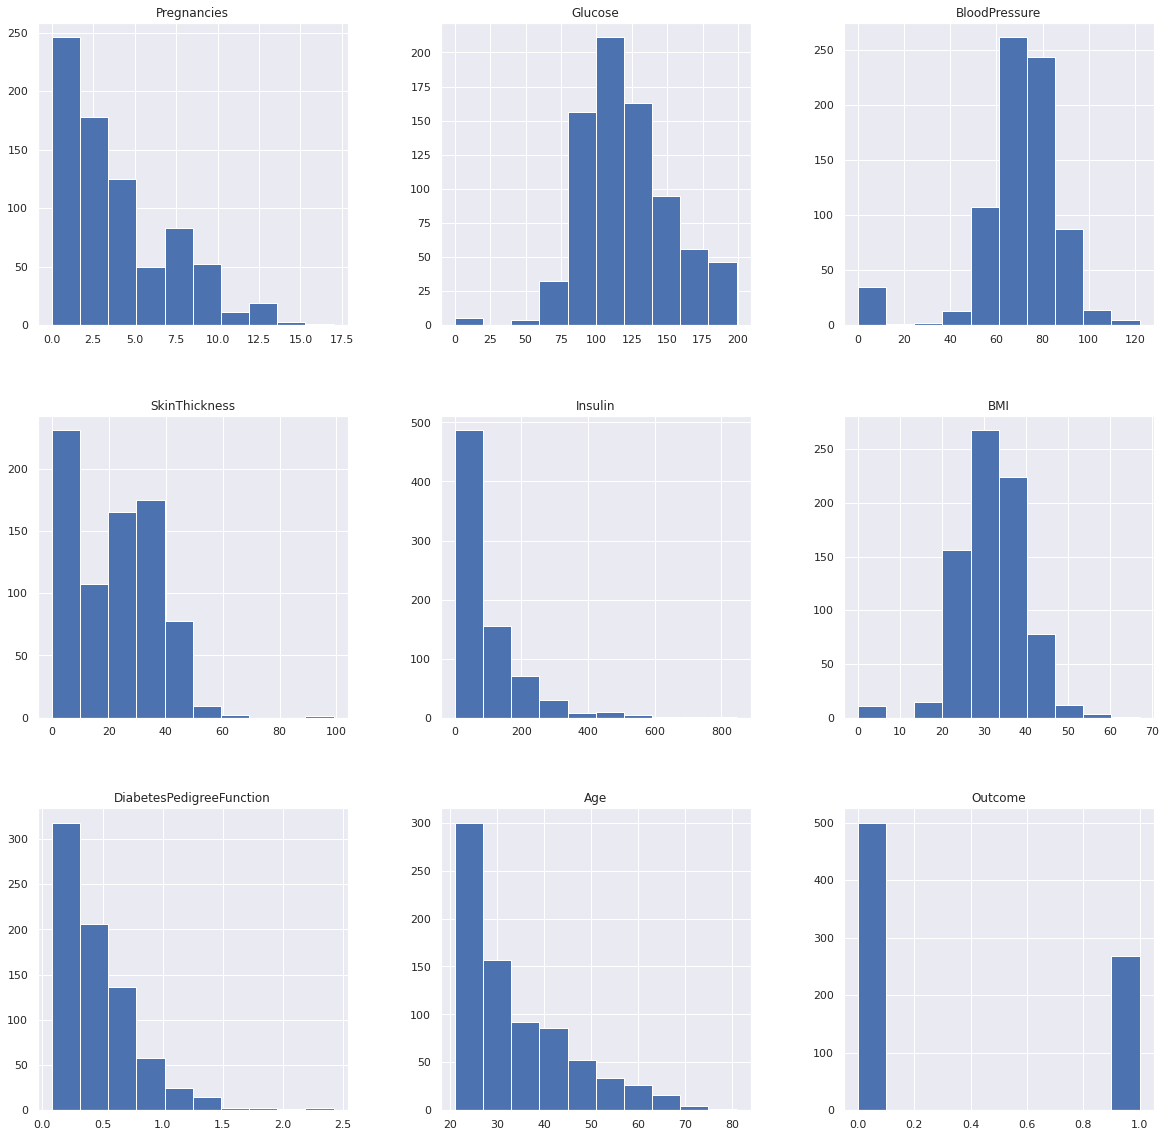

In [11]:
plot= df.hist(figsize = (20,20))

In [12]:
df_copy = df.copy(deep = True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print(df_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Replacing nan values for the columns in accordance with their distribution


In [13]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace = True)



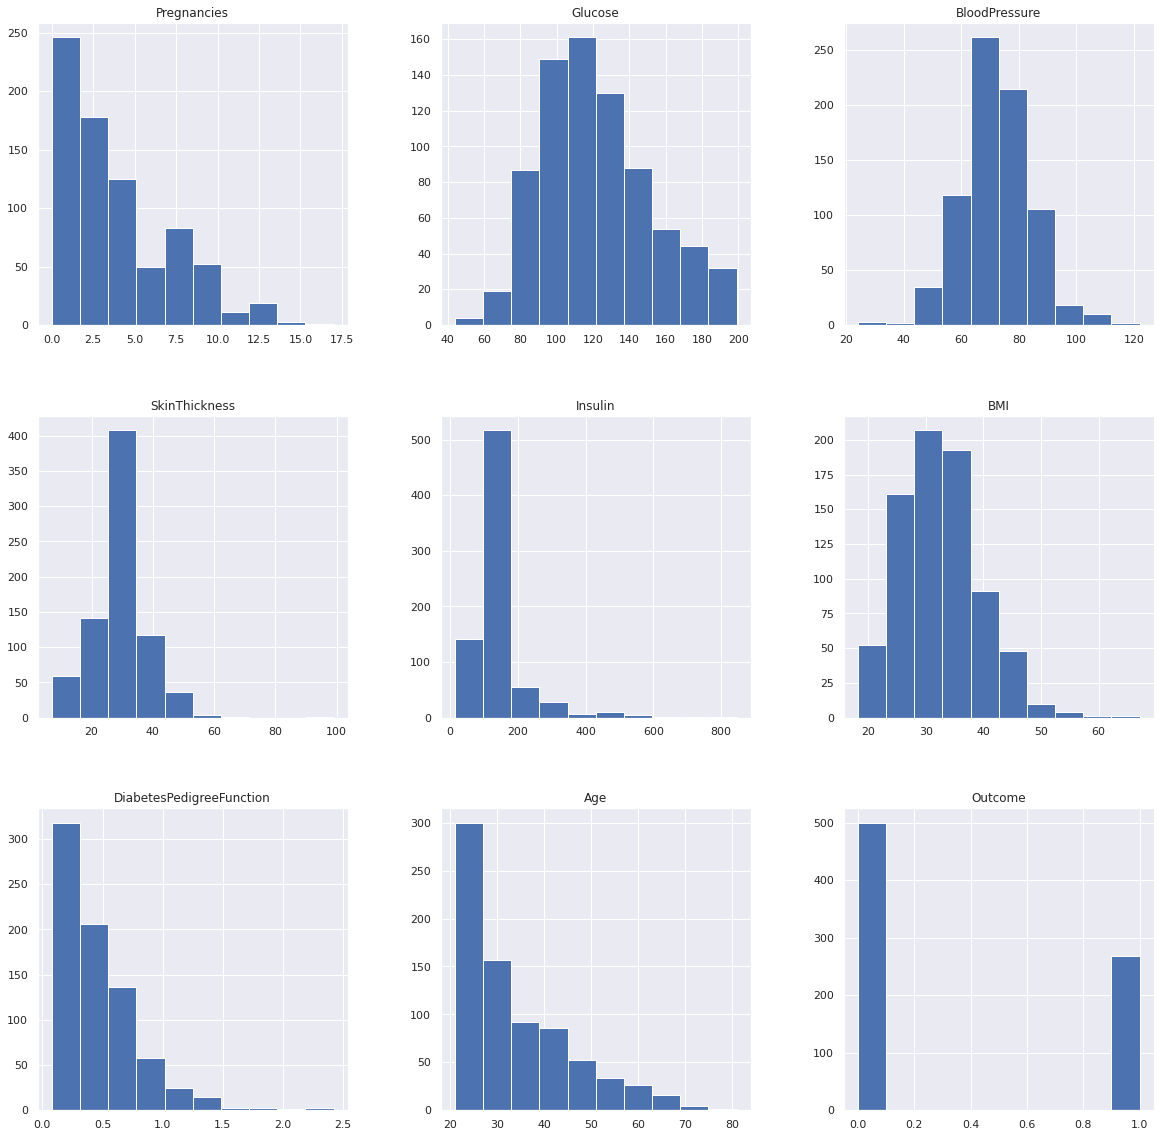

In [14]:
_=df_copy.hist(figsize =(20,20))

## null count analysis



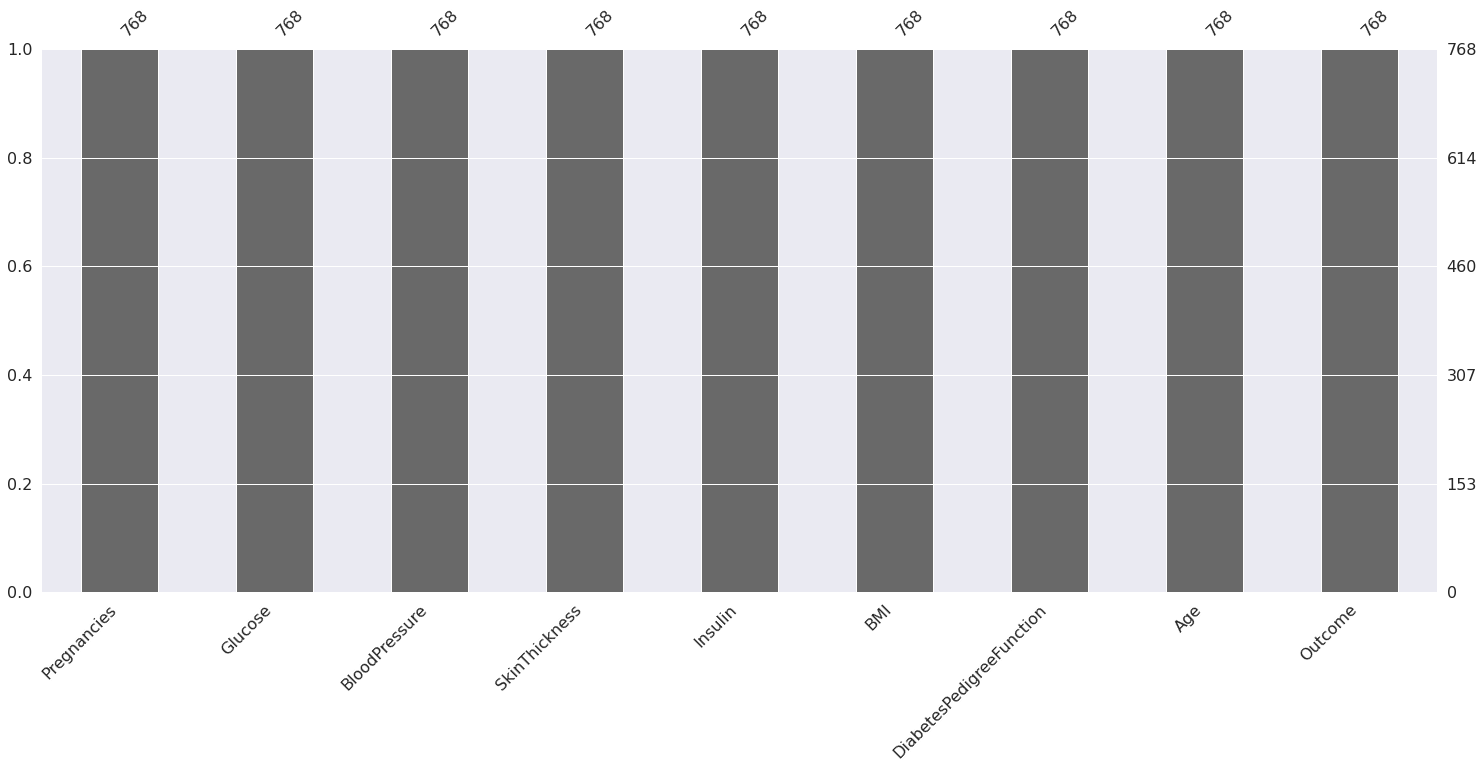

In [15]:
p=msno.bar(df)

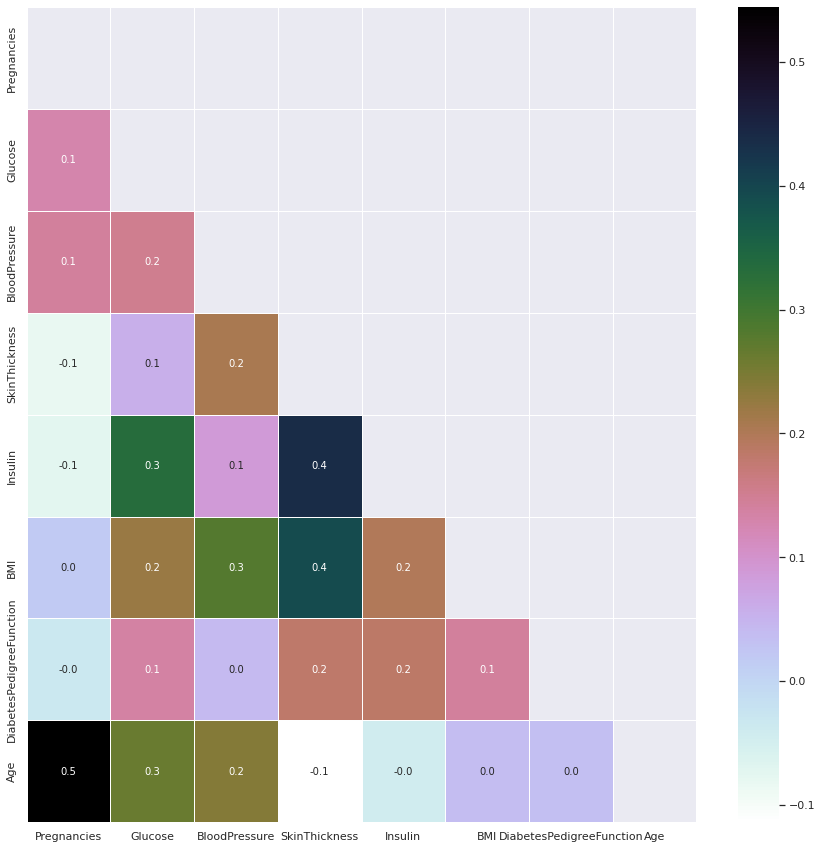

In [16]:
# Correlation visualisation
# Heatmap is good method to visualize correlation between features.
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
f,ax = plt.subplots(figsize=(15,15))
matrix = np.triu(df[cols].corr())
sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, fmt='.1f',mask=matrix, ax=ax,cmap='cubehelix_r')
plt.savefig('Corr.jpg')

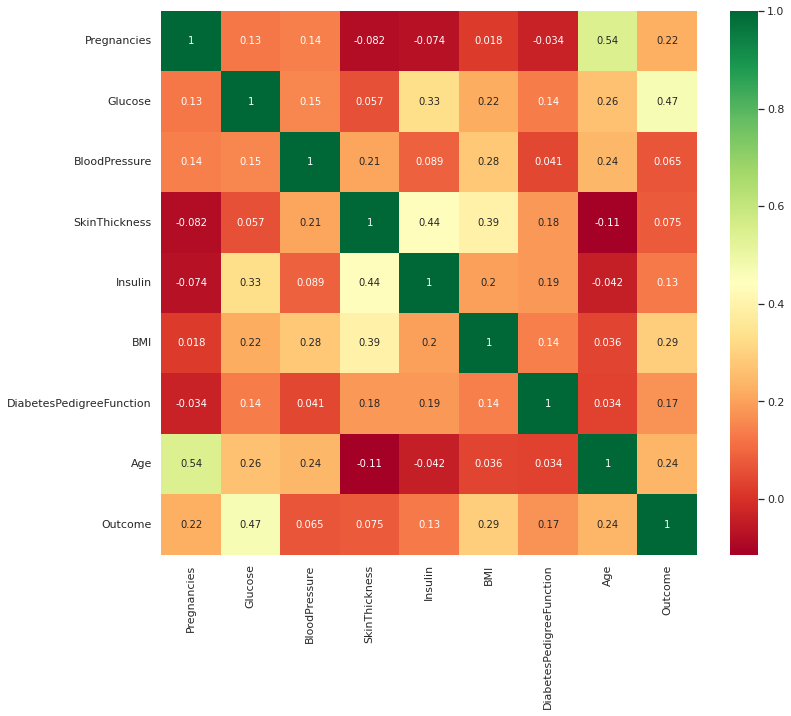

In [17]:
plt.figure(figsize=(12,10)) 
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')

In [18]:
truediabetes= df.loc[df['Outcome']==1]
truediabetes.mean()


Pregnancies                   4.865672
Glucose                     141.257463
BloodPressure                70.824627
SkinThickness                22.164179
Insulin                     100.335821
BMI                          35.142537
DiabetesPedigreeFunction      0.550500
Age                          37.067164
Outcome                       1.000000
dtype: float64

In [19]:
falsediabetes= df.loc[df['Outcome']==0]
falsediabetes.mean()


Pregnancies                   3.298000
Glucose                     109.980000
BloodPressure                68.184000
SkinThickness                19.664000
Insulin                      68.792000
BMI                          30.304200
DiabetesPedigreeFunction      0.429734
Age                          31.190000
Outcome                       0.000000
dtype: float64

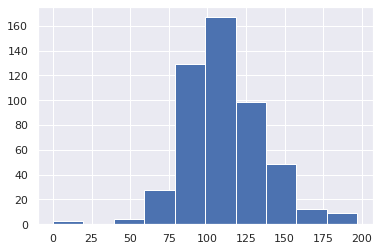

In [20]:
F = df.loc[df['Outcome'] == 0, 'Glucose'].hist()


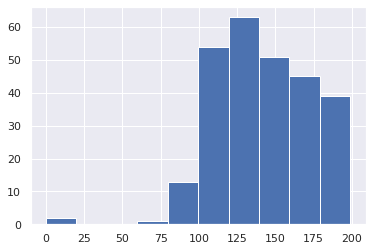

In [21]:
T= df.loc[df['Outcome']==1, 'Glucose'].hist()


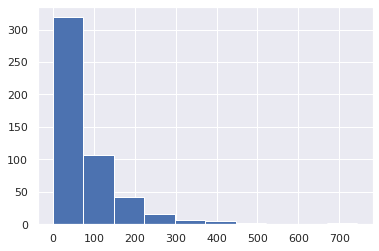

In [22]:
FI = df.loc[df['Outcome']==0, 'Insulin'].hist()


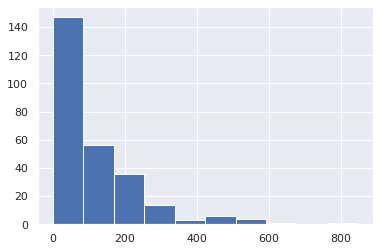

In [23]:
TI = df.loc[df['Outcome']==1, 'Insulin'].hist()


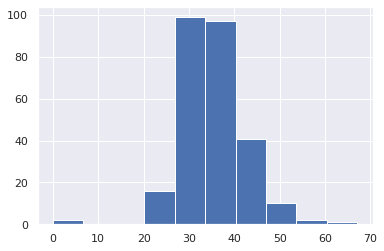

In [24]:
TB = df.loc[df['Outcome']==1, 'BMI'].hist()


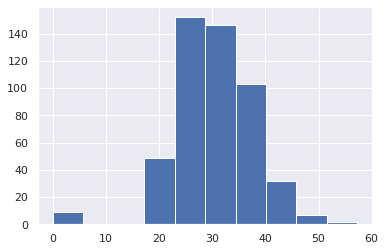

In [25]:
FB = df.loc[df['Outcome']==0, 'BMI'].hist()


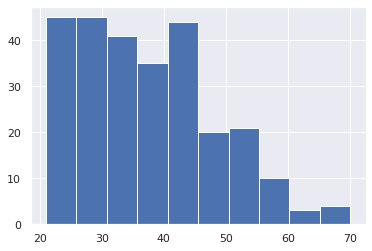

In [26]:
TA = df.loc[df['Outcome']==1, 'Age'].hist()


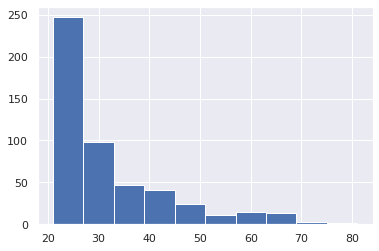

In [27]:
FA = df.loc[df['Outcome']==0, 'Age'].hist()

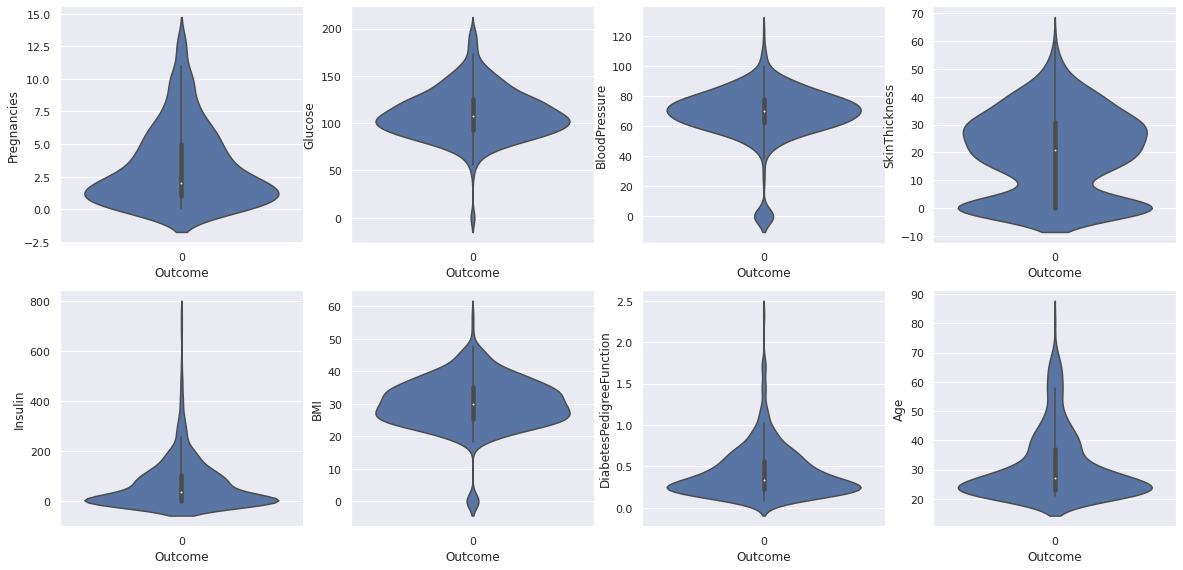

In [28]:
plt.figure(figsize=(20, 20))

for column_index, column in enumerate(falsediabetes.columns):
    if column == 'Outcome':
        continue
    plt.subplot(4, 4, column_index + 1)
    sns.violinplot(x='Outcome', y=column, data=falsediabetes)

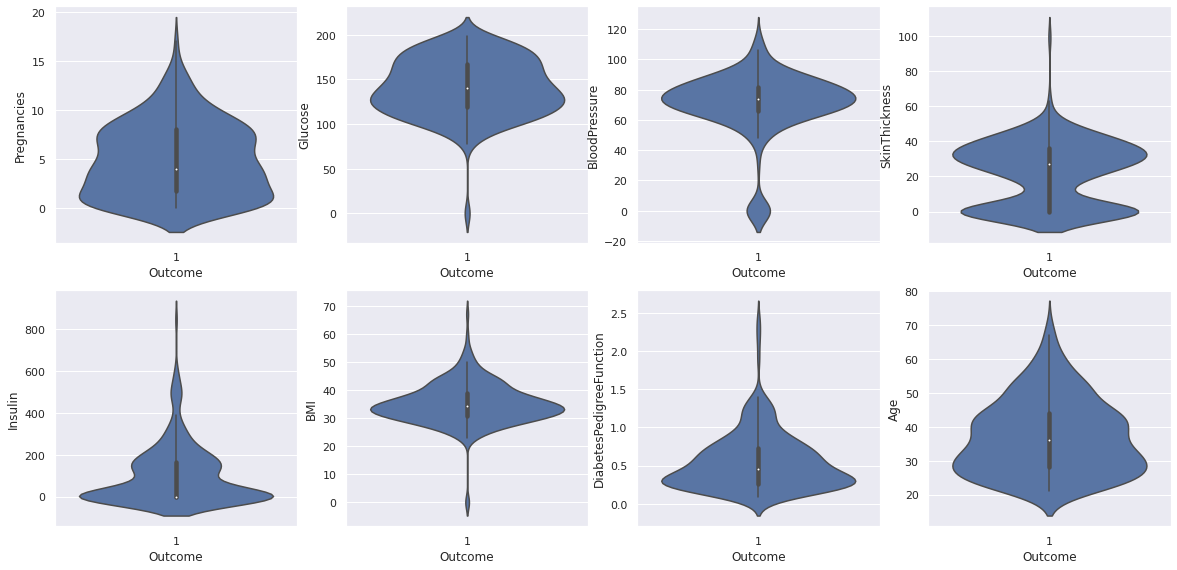

In [29]:
plt.figure(figsize=(20, 20))

for column_index, column in enumerate(truediabetes.columns):
    if column == 'Outcome':
        continue
    plt.subplot(4, 4, column_index + 1)
    sns.violinplot(x='Outcome', y=column, data=truediabetes)

# Account/s3 setup

In [30]:
# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10)

# Account/s3 setup
session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = "sagemaker/autogluon-tabular"
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
)
account = client.get_caller_identity()["Account"]

registry_uri_training = sagemaker.image_uris.retrieve(
    "mxnet",
    region,
    version="1.7.0",
    py_version="py3",
    instance_type="ml.m5.2xlarge",
    image_scope="training",
)
registry_uri_inference = sagemaker.image_uris.retrieve(
    "mxnet",
    region,
    version="1.7.0",
    py_version="py3",
    instance_type="ml.m5.2xlarge",
    image_scope="inference",
)
ecr_uri_prefix = account + "." + ".".join(registry_uri_training.split("/")[0].split(".")[1:])

## Build Docker Images (ECR)

In [31]:
training_algorithm_name = "autogluon-sagemaker-training"
inference_algorithm_name = "autogluon-sagemaker-inference"

In [32]:
subprocess.run(
    f"/bin/bash ./container-training/build_push_training.sh {account} {region} {training_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_training}",
    shell=True,
)
subprocess.run("docker system prune -af", shell=True)

CompletedProcess(args='/bin/bash ./container-training/build_push_training.sh 495962688195 us-east-1 autogluon-sagemaker-training 495962688195.dkr.ecr.us-east-1.amazonaws.com 763104351884 763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.7.0-cpu-py3', returncode=127)

CompletedProcess(args='docker system prune -af', returncode=127)

In [33]:
subprocess.run(
    f"/bin/bash ./container-inference/build_push_inference.sh {account} {region} {inference_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_inference}",
    shell=True,
)
subprocess.run("docker system prune -af", shell=True)

CompletedProcess(args='/bin/bash ./container-inference/build_push_inference.sh 495962688195 us-east-1 autogluon-sagemaker-inference 495962688195.dkr.ecr.us-east-1.amazonaws.com 763104351884 763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.7.0-cpu-py3', returncode=127)

CompletedProcess(args='docker system prune -af', returncode=127)

# Split train/test data

In [34]:

train = df.sample(frac=0.7, random_state=42)
test = df.drop(train.index)

label = "Outcome"
y_test = test[label]
X_test = test.drop(columns=[label])


In [35]:
train.head(3)
train.shape



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,58,33,190,34.0,0.430,43,0
324,2,112,75,32,0,35.7,0.148,21,0
624,2,108,64,0,0,30.8,0.158,21,0


(538, 9)

In [36]:
test.head(3)
test.shape

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,0
4,0,137,40,35,168,43.1,2.288,33,1
8,2,197,70,45,543,30.5,0.158,53,1


(230, 9)

In [37]:
X_test.head(3)
X_test.shape


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1,1,85,66,29,0,26.6,0.351,31
4,0,137,40,35,168,43.1,2.288,33
8,2,197,70,45,543,30.5,0.158,53


(230, 8)

## Upload data to S3

In [38]:
train_file = "train.csv"
train.to_csv(train_file, index=False)
train_s3_path = session.upload_data(train_file, key_prefix="{}/data".format(prefix))

test_file = "test.csv"
test.to_csv(test_file, index=False)
test_s3_path = session.upload_data(test_file, key_prefix="{}/data".format(prefix))


X_test_file = "X_test.csv"
X_test.to_csv(X_test_file, index=False)
X_test_s3_path = session.upload_data(X_test_file, key_prefix="{}/data".format(prefix))

## Model Hyperparameter Selection


**Requirements:

We are predicting outcome, so it is the label we are setting.

Use the root_mean_squared_error as the metric to use for evaluation.
Set a time limit of 10 minutes (600 seconds).
Use the preset best_quality to focus on creating the best mode

In [39]:
nn_options = {
    'num_epochs': "10",
    'learning_rate': "ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)",
    'activation': "ag.space.Categorical('relu', 'softrelu', 'tanh')",
    'layers': "ag.space.Categorical([100],[1000],[200,100],[300,200,100])",
    'dropout_prob': "ag.space.Real(0.0, 0.5, default=0.1)"
}

gbm_options = {
    'num_boost_round': "100",
    'num_leaves': "ag.space.Int(lower=26, upper=66, default=36)"
}

model_hps = {'NN': nn_options, 'GBM': gbm_options}

init_args = {
  'eval_metric' : 'roc_auc',
  'label': 'Outcome'
}

fit_args = {
  'presets': ['best_quality', 'optimize_for_deployment'],
  'time_limits': 600,
  'hyperparameters': model_hps,
  'hyperparameter_tune': True,
  'search_strategy': 'skopt'
}


hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}

tags = [{"Key": "AlgorithmName", "Value": "AutoGluon-Tabular"}]


## Train

In [43]:
%%time

instance_type = "ml.m5.2xlarge"
# instance_type = 'local'

ecr_image = f"{ecr_uri_prefix}/{training_algorithm_name}:latest"

estimator = Estimator(
    image_uri=ecr_image,
    role=role,
    instance_count=3,
    instance_type=instance_type,
    hyperparameters=hyperparameters,
    volume_size=100,
    tags=tags,
)

# Set inputs. Test data is optional, but requires a label column.
inputs = {"training": train_s3_path, "testing": test_s3_path}

estimator.fit(inputs)

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: Cannot find repository: autogluon-sagemaker-training in registry ID: 495962688195 Please check if your ECR repository exists and role arn:aws:iam::495962688195:role/service-role/AmazonSageMaker-ExecutionRole-20230305T162998 has proper pull permissions for SageMaker: ecr:BatchCheckLayerAvailability, ecr:BatchGetImage, ecr:GetDownloadUrlForLayer

## Debug

## Deploy

## Test

## Clean up endpoint



In [44]:
predictor.delete_endpoint()
